In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
import xgboost as xgb
from folium.plugins import HeatMap
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from utils import evaluate_model, evaluate_model_full

In [2]:
# Import the dataset
df = pd.read_csv('data\credit_card_transactions.csv')

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\chees\AppData\Local\Temp\ipykernel_20020\2300352932.py:2: SyntaxWarning: invalid escape sequence '\c'
  df = pd.read_csv('data\credit_card_transactions.csv')


Exploratory Data Analysis

In [3]:
# Convert trans_date_trans_time into separate columns
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_year'] = df['trans_date_trans_time'].dt.year
df['trans_month']= df['trans_date_trans_time'].dt.month_name()
df['trans_day']= df['trans_date_trans_time'].dt.day
df['trans_day_name']= df['trans_date_trans_time'].dt.day_name()
df['trans_hour']= df['trans_date_trans_time'].dt.hour
df.head()

Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...   unix_time  merch_lat  \
0    Banks      F                561 Perry Cove  ...  1325376018  36.011293   
1     Gill      F  43039 Riley Greens Suite 393  ...  1325376044  49.159047   
2  Sanchez      M      594 White Dale Suite 530  ...  1325376051  43.150704   
3    White      M   9443 Cynthia Court Apt. 038  ...  1325376076  47.034331   
4   Garcia      M              408 Bradley Rest  ...  1325376186  38.674999   

   merch_long  is_fraud  merch_zipcode  trans_year trans_month trans_day  \
0  -82.048315         0        28705.0        2019     January         1   
1 -118.186462         0            NaN        2019     January         1   
2 -112.154481         0        83236.0        2019     January         1   
3 -112.561071         0            NaN        2019     January         1   
4  -78.632459         0        22844.0        2019     January         1   

  trans_day_name  trans_hour  
0        Tuesday           0  
1        Tuesday           0  
2        Tuesday           0  
3        Tuesday           0  
4        Tuesday           0  

[5 rows x 29 columns]

In [4]:
# Create bins to categorize the hours of the day
bins = [0, 4, 8, 12, 16, 20, 24]
labels = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']
df['trans_hour_bin'] = pd.cut(df['trans_hour'], bins=bins, labels=labels, right=False)
df.head()

Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...  merch_lat  merch_long  \
0    Banks      F                561 Perry Cove  ...  36.011293  -82.048315   
1     Gill      F  43039 Riley Greens Suite 393  ...  49.159047 -118.186462   
2  Sanchez      M      594 White Dale Suite 530  ...  43.150704 -112.154481   
3    White      M   9443 Cynthia Court Apt. 038  ...  47.034331 -112.561071   
4   Garcia      M              408 Bradley Rest  ...  38.674999  -78.632459   

   is_fraud  merch_zipcode  trans_year  trans_month trans_day trans_day_name  \
0         0        28705.0        2019      January         1        Tuesday   
1         0            NaN        2019      January         1        Tuesday   
2         0        83236.0        2019      January         1        Tuesday   
3         0            NaN        2019      January         1        Tuesday   
4         0        22844.0        2019      January         1        Tuesday   

  trans_hour  trans_hour_bin  
0          0             0-4  
1          0             0-4  
2          0             0-4  
3          0             0-4  
4          0             0-4  

[5 rows x 30 columns]

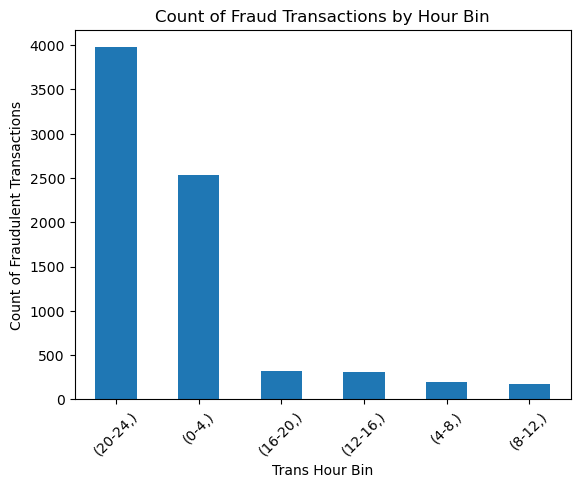

In [5]:
# Plot bar chart to see the count of fraud transactions by hour bin
df[df['is_fraud']==1][['trans_hour_bin']].value_counts().plot(kind='bar')
plt.title('Count of Fraud Transactions by Hour Bin')
plt.xlabel('Trans Hour Bin')
plt.ylabel('Count of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

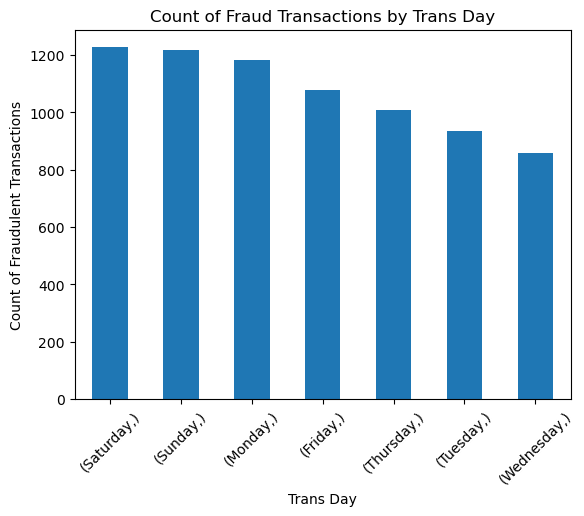

In [6]:
# Plot bar chart to see the count of fraud transactions by day of the week
df[df['is_fraud']==1][['trans_day_name']].value_counts().plot(kind='bar')
plt.title('Count of Fraud Transactions by Trans Day')
plt.xlabel('Trans Day')
plt.ylabel('Count of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

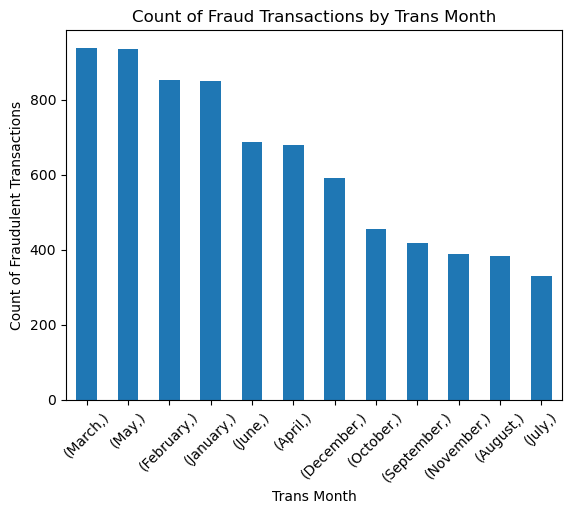

In [7]:
# Plot bar chart to see the count of fraud transactions by month
df[df['is_fraud']==1][['trans_month']].value_counts().plot(kind='bar')
plt.title('Count of Fraud Transactions by Trans Month')
plt.xlabel('Trans Month')
plt.ylabel('Count of Fraudulent Transactions')
plt.xticks(rotation=45)
plt.show()

C:\Users\chees\AppData\Local\Temp\ipykernel_20020\3612324399.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table_bins_day = df[df['is_fraud'] == 1].pivot_table(index='trans_month', columns='trans_hour_bin', aggfunc='size')


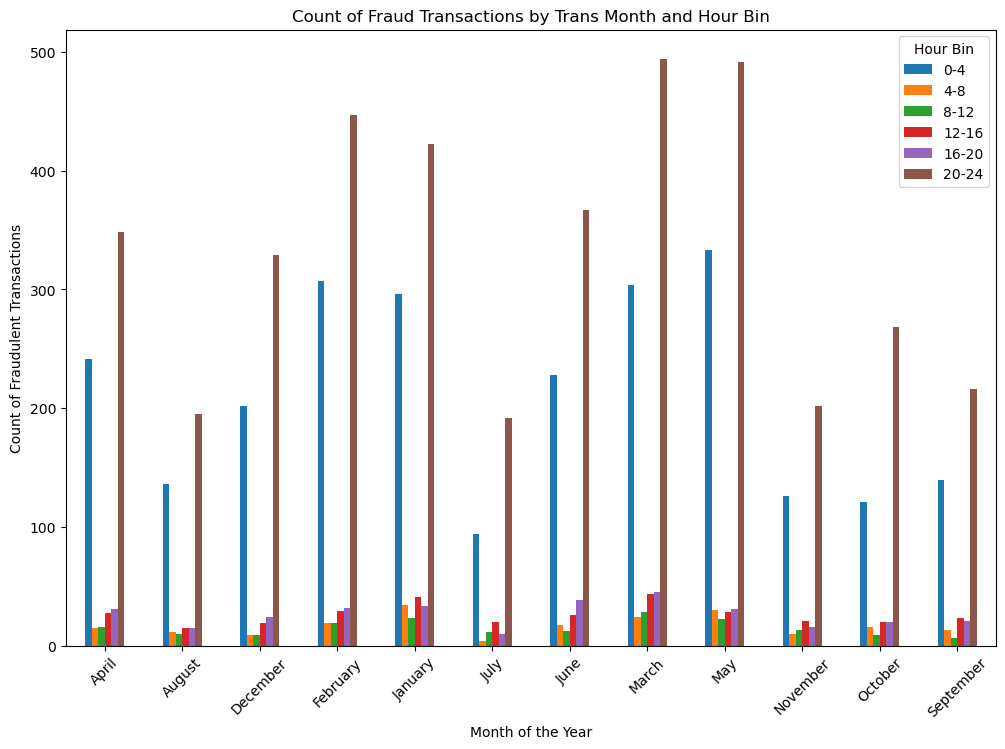

In [8]:
# Filter out the non-fraud transactions and create a pivot table by month and hour bin
pivot_table_bins_day = df[df['is_fraud'] == 1].pivot_table(index='trans_month', columns='trans_hour_bin', aggfunc='size')

# Plot bar chart to show the count of fraud transactions by month and hour bin
pivot_table_bins_day.plot(kind='bar', figsize=(12, 8))
plt.title('Count of Fraud Transactions by Trans Month and Hour Bin')
plt.xlabel('Month of the Year')
plt.ylabel('Count of Fraudulent Transactions')
plt.legend(title='Hour Bin')
plt.xticks(rotation=45)
plt.show()

In [9]:
# Filter out non-fraud transactions
df_fraud = df[df['is_fraud'] == 1]

# Group by year, category, and count the occurrences
fraud_counts = df_fraud.groupby(['trans_year', 'category']).size().unstack()
fraud_counts = fraud_counts.loc[:, fraud_counts.sum().sort_values(ascending=False).index]

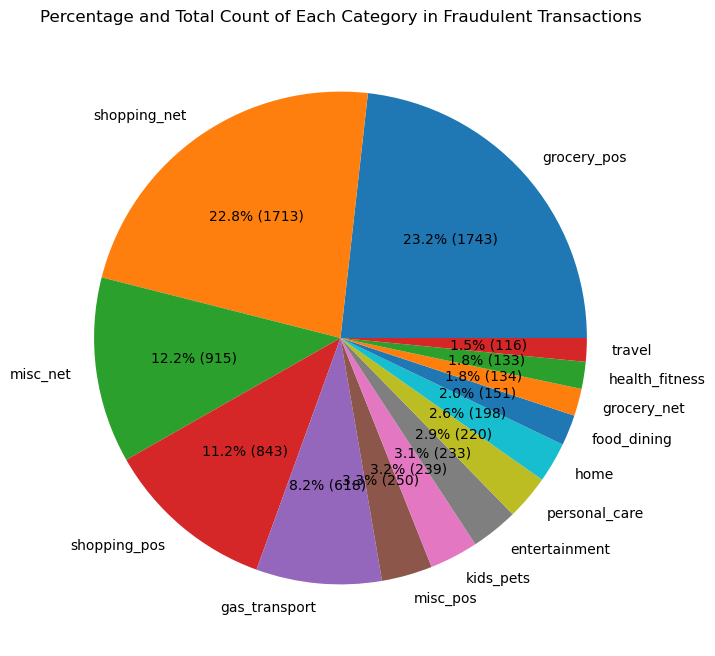

In [10]:
# Plot pie chart to see percentage of fraudulent transactions and total count of each category
category_counts = df_fraud['category'].value_counts()
plt.figure(figsize=(10, 8))
plt.pie(category_counts, labels=category_counts.index, autopct=lambda p: '{:.1f}% ({:.0f})'.format(p, (p/100)*sum(category_counts)))
plt.title('Percentage and Total Count of Each Category in Fraudulent Transactions')
plt.show()

In [11]:
# Categorize by gender and category 
df_cat = df[['gender','category']]

In [12]:
# Use the label encoder to encode categorical columns
le = LabelEncoder()
cols = ['gender', 'category']
for col in cols:
    df_cat[col] = le.fit_transform(df_cat[col])
df_cat.head()

C:\Users\chees\AppData\Local\Temp\ipykernel_20020\2506119669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = le.fit_transform(df_cat[col])
C:\Users\chees\AppData\Local\Temp\ipykernel_20020\2506119669.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[col] = le.fit_transform(df_cat[col])


gender  category
0       0         8
1       0         4
2       1         0
3       1         2
4       1         9

In [13]:
# Add amount, is_fraud, and zip columns to the categorical df 
df_cat[['amt','is_fraud', 'zip']] = df[['amt','is_fraud', 'zip']]

# Filter by fraudulent transactions
df_cat_fraud = df_cat[df_cat['is_fraud'] == 1]

C:\Users\chees\AppData\Local\Temp\ipykernel_20020\363101531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[['amt','is_fraud', 'zip']] = df[['amt','is_fraud', 'zip']]
C:\Users\chees\AppData\Local\Temp\ipykernel_20020\363101531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[['amt','is_fraud', 'zip']] = df[['amt','is_fraud', 'zip']]
C:\Users\chees\AppData\Local\Temp\ipykernel_20020\363101531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [14]:
# Group by gender, category, and zip and sum the amount and merge city_pop column
df_cat_fraud = df_cat_fraud.groupby(['gender','category','zip']).agg({'amt': 'sum'}).reset_index()
df_cat_fraud = df_cat_fraud.merge(df[['zip', 'city_pop']].drop_duplicates(), on='zip', how='left')
df_cat_fraud = df_cat_fraud.sort_values(by=['amt', 'city_pop'], ascending=[False, True])
df_cat_fraud.head()

gender  category    zip      amt  city_pop
3483       1        11   5654  8359.10       970
1799       0        11  75246  8230.28   1263321
3684       1        11  55606  8121.92       272
3781       1        11  82936  7913.70        49
3463       1        11   1843  7750.05     76383

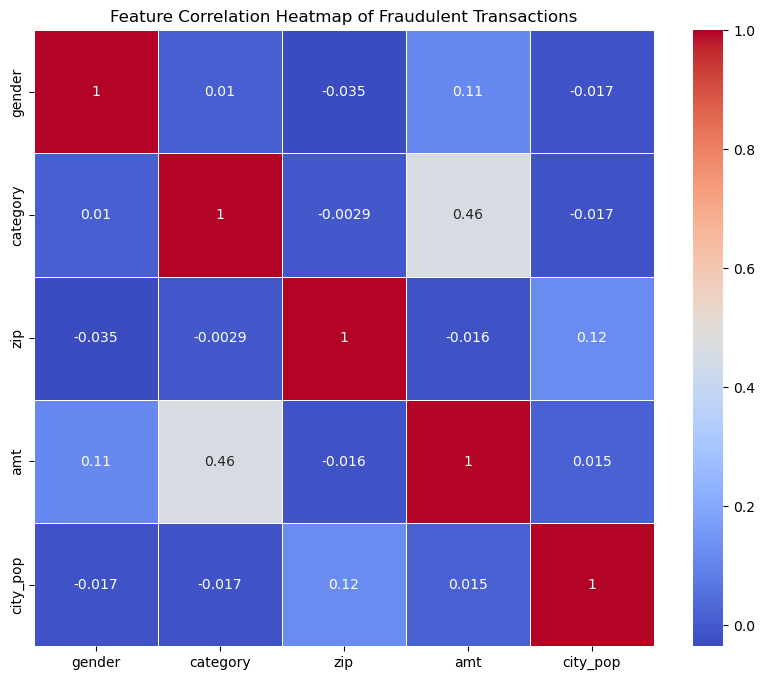

In [15]:
# Plot correlation matrix to see the relationship between the features and create a Heatmap
correlation_matrix = df_cat_fraud.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap of Fraudulent Transactions')
plt.show()

In [16]:
# Merge df with lat and log to show the location of the fraudulent transactions
df_cat_fraud = df_cat_fraud.merge(df[['zip', 'lat', 'long']].drop_duplicates(), on='zip', how='left')
df_cat_fraud.head()

gender  category    zip      amt  city_pop      lat      long
0       1        11   5654  8359.10       970  44.1554  -72.4847
1       0        11  75246  8230.28   1263321  32.7948  -96.7697
2       1        11  55606  8121.92       272  47.8342  -90.0476
3       1        11  82936  7913.70        49  41.0552 -110.1603
4       1        11   1843  7750.05     76383  42.6911  -71.1605

In [17]:
# Create a map to show the location of the fraudulent transactions
m = folium.Map(location=[37.0902, -95.7129], zoom_start=5)
heat_data = [[row['lat'], row['long']] for index, row in df_cat_fraud.iterrows()]
HeatMap(heat_data).add_to(m)
m

In [18]:
# Create a map centered around the US
m2 = folium.Map(location=[37.0902, -95.7129], zoom_start=5)

# Add fraudulent transaction locations with data labels
for index, row in df_cat_fraud.iterrows():
    folium.Marker(
        location=[row['lat'], row['long']],
        popup=f"Amount: ${row['amt']}, City Population: {row['city_pop']}",
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(m2)

m2

Modeling

In [19]:
# Drop unneccessary columns
df_dropped = df.copy()
df_dropped = df_dropped.drop(columns=['Unnamed: 0','trans_date_trans_time','cc_num','first', 'last', 'gender', 'street', 'lat', 'long', 'dob','trans_num','merch_lat', 'merch_long', 'unix_time','city', 'state','trans_year','trans_month', 'trans_day', 'trans_day_name', 'trans_hour','trans_hour_bin'])
df_dropped.head()

merchant       category     amt    zip  city_pop  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97  28654      3495   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  99160       149   
2                fraud_Lind-Buckridge  entertainment  220.11  83252      4154   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00  59632      1939   
4                 fraud_Keeling-Crist       misc_pos   41.96  24433        99   

                                 job  is_fraud  merch_zipcode  
0          Psychologist, counselling         0        28705.0  
1  Special educational needs teacher         0            NaN  
2        Nature conservation officer         0        83236.0  
3                    Patent attorney         0            NaN  
4     Dance movement psychotherapist         0        22844.0

In [20]:
# Fill the missing values
df_dropped['merch_zipcode'] = df_dropped['merch_zipcode'].fillna(df_dropped['zip'])

In [21]:
# Filter out the rows where the amount is greater than 10000
df_copy = df_dropped.copy()
df_copy = df_copy[df_copy['amt'] < 10000]

In [22]:
# One-hot encode the category column
dummies = pd.get_dummies(df_copy['category'], drop_first=True, dtype=int)
df_copy = pd.concat([df_copy, dummies], axis=1)
df_copy = df_copy.drop(columns=['category'])
df_copy.head()

merchant     amt    zip  city_pop  \
0          fraud_Rippin, Kub and Mann    4.97  28654      3495   
1     fraud_Heller, Gutmann and Zieme  107.23  99160       149   
2                fraud_Lind-Buckridge  220.11  83252      4154   
3  fraud_Kutch, Hermiston and Farrell   45.00  59632      1939   
4                 fraud_Keeling-Crist   41.96  24433        99   

                                 job  is_fraud  merch_zipcode  food_dining  \
0          Psychologist, counselling         0        28705.0            0   
1  Special educational needs teacher         0        99160.0            0   
2        Nature conservation officer         0        83236.0            0   
3                    Patent attorney         0        59632.0            0   
4     Dance movement psychotherapist         0        22844.0            0   

   gas_transport  grocery_net  grocery_pos  health_fitness  home  kids_pets  \
0              0            0            0               0     0          0   
1              0            0            1               0     0          0   
2              0            0            0               0     0          0   
3              1            0            0               0     0          0   
4              0            0            0               0     0          0   

   misc_net  misc_pos  personal_care  shopping_net  shopping_pos  travel  
0         1         0              0             0             0       0  
1         0         0              0             0             0       0  
2         0         0              0             0             0       0  
3         0         0              0             0             0       0  
4         0         1              0             0             0       0

In [23]:
# Scale the numerical columns
scaler = StandardScaler()
df_scaled = df_copy.copy()
df_scaled[['amt', 'zip', 'city_pop', 'merch_zipcode']] = scaler.fit_transform(df_scaled[['amt', 'zip', 'city_pop', 'merch_zipcode']])
df_scaled.head()

merchant       amt       zip  city_pop  \
0          fraud_Rippin, Kub and Mann -0.469521 -0.749142 -0.282589   
1     fraud_Heller, Gutmann and Zieme  0.269247  1.872566 -0.293670   
2                fraud_Lind-Buckridge  1.084737  1.281040 -0.280406   
3  fraud_Kutch, Hermiston and Farrell -0.180328  0.402750 -0.287742   
4                 fraud_Keeling-Crist -0.202290 -0.906096 -0.293835   

                                 job  is_fraud  merch_zipcode  food_dining  \
0          Psychologist, counselling         0      -0.754769            0   
1  Special educational needs teacher         0       1.874991            0   
2        Nature conservation officer         0       1.280622            0   
3                    Patent attorney         0       0.399593            0   
4     Dance movement psychotherapist         0      -0.973533            0   

   gas_transport  grocery_net  grocery_pos  health_fitness  home  kids_pets  \
0              0            0            0               0     0          0   
1              0            0            1               0     0          0   
2              0            0            0               0     0          0   
3              1            0            0               0     0          0   
4              0            0            0               0     0          0   

   misc_net  misc_pos  personal_care  shopping_net  shopping_pos  travel  
0         1         0              0             0             0       0  
1         0         0              0             0             0       0  
2         0         0              0             0             0       0  
3         0         0              0             0             0       0  
4         0         1              0             0             0       0

In [24]:
# Scale the merchant column
merch_freq = df_scaled['merchant'].value_counts()
df_scaled['merchant_encoded'] = df_scaled['merchant'].apply(lambda x: merch_freq[x])
df_scaled = df_scaled.drop(columns=['merchant'])
df_scaled.head()

amt       zip  city_pop                                job  is_fraud  \
0 -0.469521 -0.749142 -0.282589          Psychologist, counselling         0   
1  0.269247  1.872566 -0.293670  Special educational needs teacher         0   
2  1.084737  1.281040 -0.280406        Nature conservation officer         0   
3 -0.180328  0.402750 -0.287742                    Patent attorney         0   
4 -0.202290 -0.906096 -0.293835     Dance movement psychotherapist         0   

   merch_zipcode  food_dining  gas_transport  grocery_net  grocery_pos  \
0      -0.754769            0              0            0            0   
1       1.874991            0              0            0            1   
2       1.280622            0              0            0            0   
3       0.399593            0              1            0            0   
4      -0.973533            0              0            0            0   

   health_fitness  home  kids_pets  misc_net  misc_pos  personal_care  \
0               0     0          0         1         0              0   
1               0     0          0         0         0              0   
2               0     0          0         0         0              0   
3               0     0          0         0         0              0   
4               0     0          0         0         1              0   

   shopping_net  shopping_pos  travel  merchant_encoded  
0             0             0       0              1267  
1             0             0       0              2503  
2             0             0       0              1895  
3             0             0       0              2613  
4             0             0       0              1592

In [25]:
# Scale the job column
job_freq = df_scaled['job'].value_counts()
df_scaled['job_encoded'] = df_scaled['job'].apply(lambda x: job_freq[x])
df_scaled = df_scaled.drop(columns=['job'])
df_scaled.head()

amt       zip  city_pop  is_fraud  merch_zipcode  food_dining  \
0 -0.469521 -0.749142 -0.282589         0      -0.754769            0   
1  0.269247  1.872566 -0.293670         0       1.874991            0   
2  1.084737  1.281040 -0.280406         0       1.280622            0   
3 -0.180328  0.402750 -0.287742         0       0.399593            0   
4 -0.202290 -0.906096 -0.293835         0      -0.973533            0   

   gas_transport  grocery_net  grocery_pos  health_fitness  home  kids_pets  \
0              0            0            0               0     0          0   
1              0            0            1               0     0          0   
2              0            0            0               0     0          0   
3              1            0            0               0     0          0   
4              0            0            0               0     0          0   

   misc_net  misc_pos  personal_care  shopping_net  shopping_pos  travel  \
0         1         0              0             0             0       0   
1         0         0              0             0             0       0   
2         0         0              0             0             0       0   
3         0         0              0             0             0       0   
4         0         1              0             0             0       0   

   merchant_encoded  job_encoded  
0              1267         3545  
1              2503         5099  
2              1895          511  
3              2613         2530  
4              1592         2017

In [26]:
# Split the data into training and testing sets
X = df_scaled.drop(columns=['is_fraud'])
y = df_scaled['is_fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [27]:
# Resample the data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [28]:
# Perform a PCA on the data
pca_model = PCA(n_components = 10)
pca_model.fit(X_train)

X_train_pca = pd.DataFrame(pca_model.transform(X_train))
X_test_pca = pd.DataFrame(pca_model.transform(X_test))

In [29]:
# Define a SGD model
SGD = SGDClassifier(loss = 'log_loss', max_iter=5000, tol=1e-3, random_state=42)

In [30]:
# Evaluate the SGD model
evaluate_model_full(SGD, X_train, y_train, X_test, y_test, X_train_resampled, y_train_resampled, X_train_pca, X_test_pca)

Unprocessed Data Metrics:
Accuracy Score:
0.9933736630871697

Confusion Matrix:
[[321774    513]
 [  1635    239]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    322287
           1       0.32      0.13      0.18      1874

    accuracy                           0.99    324161
   macro avg       0.66      0.56      0.59    324161
weighted avg       0.99      0.99      0.99    324161


Resampled Data Metrics:
Accuracy Score:
0.969780448604243

Confusion Matrix:
[[312987   9300]
 [   496   1378]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    322287
           1       0.13      0.74      0.22      1874

    accuracy                           0.97    324161
   macro avg       0.56      0.85      0.60    324161
weighted avg       0.99      0.97      0.98    324161


PCA Data Metrics:
Accuracy Score:
0.9944687979121486

Confusion Matri

In [31]:
# Define a Decision Tree model
DTC = DecisionTreeClassifier(random_state=42, max_depth=5)

In [32]:
# Evaluate the Decision Tree model
evaluate_model_full(DTC, X_train, y_train, X_test, y_test, X_train_resampled, y_train_resampled, X_train_pca, X_test_pca)

Unprocessed Data Metrics:
Accuracy Score:
0.9969490469242136

Confusion Matrix:
[[322020    267]
 [   722   1152]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322287
           1       0.81      0.61      0.70      1874

    accuracy                           1.00    324161
   macro avg       0.90      0.81      0.85    324161
weighted avg       1.00      1.00      1.00    324161


Resampled Data Metrics:
Accuracy Score:
0.9697835334910739

Confusion Matrix:
[[312758   9529]
 [   266   1608]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    322287
           1       0.14      0.86      0.25      1874

    accuracy                           0.97    324161
   macro avg       0.57      0.91      0.62    324161
weighted avg       0.99      0.97      0.98    324161


PCA Data Metrics:
Accuracy Score:
0.9963289846711973

Confusion Matr

In [33]:
# Define an XGBoost model
XGB = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

In [34]:
# Evaluate the XGBoost model
evaluate_model_full(XGB, X_train, y_train, X_test, y_test, X_train_resampled, y_train_resampled, X_train_pca, X_test_pca)

Unprocessed Data Metrics:
Accuracy Score:
0.9968410758851312

Confusion Matrix:
[[322032    255]
 [   769   1105]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322287
           1       0.81      0.59      0.68      1874

    accuracy                           1.00    324161
   macro avg       0.91      0.79      0.84    324161
weighted avg       1.00      1.00      1.00    324161


Resampled Data Metrics:
Accuracy Score:
0.9845663111848741

Confusion Matrix:
[[317554   4733]
 [   270   1604]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    322287
           1       0.25      0.86      0.39      1874

    accuracy                           0.98    324161
   macro avg       0.63      0.92      0.69    324161
weighted avg       0.99      0.98      0.99    324161


PCA Data Metrics:
Accuracy Score:
0.9970354237554795

Confusion Matr

In [35]:
# Define a Random Forest model
RFC = RandomForestClassifier(n_estimators=100, random_state=42)

In [36]:
# Evaluate the Random Forest model
evaluate_model_full(RFC, X_train, y_train, X_test, y_test, X_train_resampled, y_train_resampled, X_train_pca, X_test_pca)

Unprocessed Data Metrics:
Accuracy Score:
0.9971433947945619

Confusion Matrix:
[[322033    254]
 [   672   1202]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322287
           1       0.83      0.64      0.72      1874

    accuracy                           1.00    324161
   macro avg       0.91      0.82      0.86    324161
weighted avg       1.00      1.00      1.00    324161


Resampled Data Metrics:
Accuracy Score:
0.9955793571712822

Confusion Matrix:
[[321267   1020]
 [   413   1461]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    322287
           1       0.59      0.78      0.67      1874

    accuracy                           1.00    324161
   macro avg       0.79      0.89      0.83    324161
weighted avg       1.00      1.00      1.00    324161


PCA Data Metrics:
Accuracy Score:
0.9968657549797786

Confusion Matr